In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(
    "/content/drive/MyDrive/weather prediction(time-series)/processed_data/weather_processed.csv",
    index_col="Formatted Date",
    parse_dates=True
)

print(df.shape)
df.head()

(96429, 19)


,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),temp_diff,humidity_diff,pressure_diff,wind_diff,temp_roll3,hum_roll3,pres_roll6,hour,month,dayofyear
Formatted Date,,,,,,,,,,,,,,,,,,,
2005-12-31 23:00:00+00:00,0.730769,0.5,0.362884,0.352912,0.89,0.268028,0.389972,0.620,0.971597,0.539738,0.480,0.499755,0.446936,0.368167,0.830116,0.95727,1.000000,1.0,0.99726
2006-01-01 00:00:00+00:00,0.653846,0.5,0.372334,0.365007,0.85,0.260212,0.387187,0.615,0.971110,0.539738,0.480,0.499755,0.446936,0.368167,0.830116,0.95727,0.000000,0.0,0.00000
2006-01-01 01:00:00+00:00,0.653846,0.5,0.380524,0.366250,0.82,0.317196,0.389972,0.615,0.970842,0.536271,0.485,0.499865,0.501815,0.368167,0.830116,0.95727,0.043478,0.0,0.00000
2006-01-01 02:00:00+00:00,0.692308,0.5,0.381244,0.380582,0.82,0.226929,0.389972,0.615,0.970546,0.515722,0.500,0.499851,0.377109,0.374449,0.803089,0.95727,0.086957,0.0,0.00000
2006-01-01 03:00:00+00:00,0.653846,0.5,0.372694,0.372380,0.86,0.218356,0.373259,0.615,0.969992,0.490220,0.520,0.499721,0.446295,0.374573,0.806950,0.95727,0.130435,0.0,0.00000


In [4]:
SEQ_LEN = 24  # use past 24 hours
TARGET_COLS = [
    "Humidity",
    "Temperature (C)",
    "Apparent Temperature (C)",
    "Pressure (millibars)",
    "Wind Speed (km/h)"
]

In [5]:
def build_sequences_multitarget(data: pd.DataFrame, seq_len: int, target_cols):
    """
    data: preprocessed DataFrame, time-indexed
    seq_len: number of past steps in each input window
    target_cols: list of column names to predict for t+1

    Returns:
        X: (num_samples, seq_len, num_features)
        y: (num_samples, num_targets)
    """
    values = data.values
    num_rows, num_features = values.shape

    target_indices = [data.columns.get_loc(c) for c in target_cols]

    X, y = [], []
    for i in range(num_rows - seq_len - 1):
        X.append(values[i : i + seq_len, :])              # all features over past seq_len
        y.append(values[i + seq_len, target_indices])     # next-step targets

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = build_sequences_multitarget(df, SEQ_LEN, TARGET_COLS)

print("X shape:", X.shape)  # (samples, 24, num_features)
print("y shape:", y.shape)  # (samples, num_targets)
print("num features:", X.shape[-1], "num targets:", y.shape[-1])


X shape: (96404, 24, 19)
y shape: (96404, 5)
num features: 19 num targets: 5


In [6]:
n_samples = X.shape[0]

train_size = int(n_samples * 0.7)
val_size   = int(n_samples * 0.15)
test_size  = n_samples - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val   = X[train_size:train_size + val_size]
y_val   = y[train_size:train_size + val_size]

X_test  = X[train_size + val_size:]
y_test  = y[train_size + val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)


Train: (67482, 24, 19) (67482, 5)
Val:   (14460, 24, 19) (14460, 5)
Test:  (14462, 24, 19) (14462, 5)


In [7]:
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, seq_len, num_features)
        self.y = torch.from_numpy(y)  # (N, num_targets)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = WeatherDataset(X_train, y_train)
val_ds   = WeatherDataset(X_val, y_val)
test_ds  = WeatherDataset(X_test, y_test)

BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)


In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x


class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_dim: int,
        d_model: int,
        nhead: int,
        num_layers: int,
        dim_feedforward: int,
        dropout: float,
        num_targets: int,
        seq_len: int
    ):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len + 5)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # (batch, seq, feature)
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, num_targets)

    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        """
        x = self.input_proj(x)            # (batch, seq_len, d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)   # (batch, seq_len, d_model)
        # Pool over time — mean pooling
        x = x.mean(dim=1)                 # (batch, d_model)
        x = self.dropout(x)
        out = self.fc_out(x)              # (batch, num_targets)
        return out


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
input_dim   = X_train.shape[-1]
num_targets = y_train.shape[-1]

model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=128,
    nhead=4,
    num_layers=3,
    dim_feedforward=256,
    dropout=0.1,
    num_targets=num_targets,
    seq_len=SEQ_LEN
).to(device)

print(model)


TimeSeriesTransformer(
  (input_proj): Linear(in_features=19, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_out): Linear(in_features=128, out_features=5, bias=True)
)


In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 20
train_losses = []
val_losses = []


In [12]:
def run_epoch(dataloader, model, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    n_batches = 0

    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)  # (B, seq_len, input_dim)
        y_batch = y_batch.to(device)  # (B, num_targets)

        if optimizer is not None:
            optimizer.zero_grad()

        preds = model(X_batch)        # (B, num_targets)
        loss = criterion(preds, y_batch)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss / n_batches


In [13]:
best_val_loss = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = run_epoch(train_loader, model, optimizer)
    val_loss   = run_epoch(val_loader, model, optimizer=None)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = model.state_dict()

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 01 | Train Loss: 0.0114 | Val Loss: 0.0033
Epoch 02 | Train Loss: 0.0045 | Val Loss: 0.0024
Epoch 03 | Train Loss: 0.0040 | Val Loss: 0.0024
Epoch 04 | Train Loss: 0.0038 | Val Loss: 0.0018
Epoch 05 | Train Loss: 0.0037 | Val Loss: 0.0033
Epoch 06 | Train Loss: 0.0036 | Val Loss: 0.0019
Epoch 07 | Train Loss: 0.0035 | Val Loss: 0.0022
Epoch 08 | Train Loss: 0.0035 | Val Loss: 0.0024
Epoch 09 | Train Loss: 0.0034 | Val Loss: 0.0021
Epoch 10 | Train Loss: 0.0033 | Val Loss: 0.0043
Epoch 11 | Train Loss: 0.0033 | Val Loss: 0.0022
Epoch 12 | Train Loss: 0.0033 | Val Loss: 0.0019
Epoch 13 | Train Loss: 0.0032 | Val Loss: 0.0020
Epoch 14 | Train Loss: 0.0032 | Val Loss: 0.0018
Epoch 15 | Train Loss: 0.0031 | Val Loss: 0.0020
Epoch 16 | Train Loss: 0.0031 | Val Loss: 0.0020
Epoch 17 | Train Loss: 0.0031 | Val Loss: 0.0021
Epoch 18 | Train Loss: 0.0031 | Val Loss: 0.0018
Epoch 19 | Train Loss: 0.0030 | Val Loss: 0.0017
Epoch 20 | Train Loss: 0.0030 | Val Loss: 0.0020


In [14]:
if best_state is not None:
    model.load_state_dict(best_state)

In [16]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(X_batch)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

all_preds   = np.vstack(all_preds)    # (N_test, num_targets)
all_targets = np.vstack(all_targets)  # (N_test, num_targets)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

for i, col in enumerate(TARGET_COLS):
    mae  = mean_absolute_error(all_targets[:, i], all_preds[:, i])
    mse  = mean_squared_error(all_targets[:, i], all_preds[:, i])
    rmse = np.sqrt(mse)

    print(f"{col:25s} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

Humidity                  | MAE: 0.0366 | RMSE: 0.0490
Temperature (C)           | MAE: 0.0176 | RMSE: 0.0223
Apparent Temperature (C)  | MAE: 0.0159 | RMSE: 0.0209
Pressure (millibars)      | MAE: 0.0078 | RMSE: 0.0351
Wind Speed (km/h)         | MAE: 0.0362 | RMSE: 0.0507


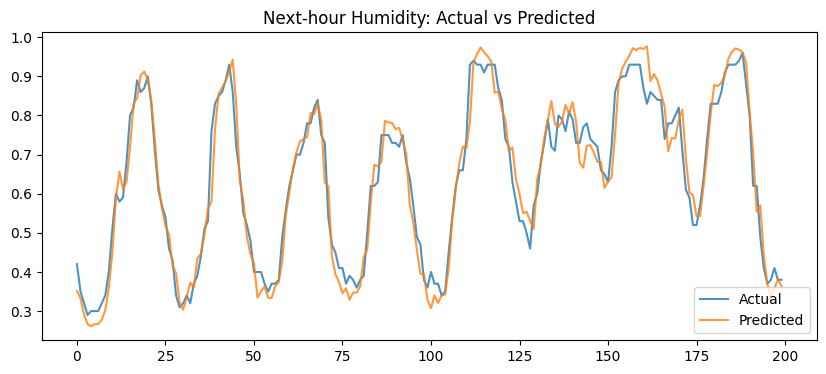

In [18]:
idx = 0  # first target: Humidity
plt.figure(figsize=(10,4))
plt.plot(all_targets[:200, idx], label="Actual", alpha=0.8)
plt.plot(all_preds[:200,   idx], label="Predicted", alpha=0.8)
plt.title("Next-hour Humidity: Actual vs Predicted")
plt.legend()
plt.show()


In [20]:
i = 200

X_sample = X_test[i]                    # shape → (24, features)
y_true   = y_test[i]                    # true next-hour targets
y_pred   = all_preds[i]                 # model predicted

# create hours axis
hours = list(range(-SEQ_LEN, 0))
next_hour = 1

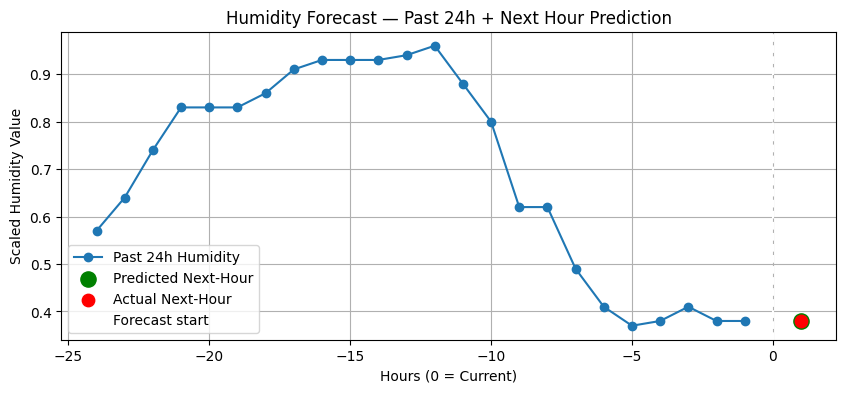

In [28]:
plt.figure(figsize=(10,4))

# Past 24 hours actual
plt.plot(hours, X_sample[:, df.columns.get_loc("Humidity")],
         label="Past 24h Humidity", marker='o')

# Next-hour prediction
plt.scatter(next_hour, y_pred[TARGET_COLS.index("Humidity")],
            color='green', s=120, label="Predicted Next-Hour")

# Next-hour true value
plt.scatter(next_hour, y_true[TARGET_COLS.index("Humidity")],
            color='red', s=80, label="Actual Next-Hour")

plt.axvline(0, linestyle='--', color='white', label='Forecast start')
plt.title("Humidity Forecast — Past 24h + Next Hour Prediction")
plt.xlabel("Hours (0 = Current)")
plt.ylabel("Scaled Humidity Value")
plt.legend()
plt.grid(True)
plt.show()


In [29]:
import os
os.makedirs("/content/drive/MyDrive/weather prediction(time-series)/saved_model", exist_ok=True)

MODEL_PATH = "/content/drive/MyDrive/weather prediction(time-series)/saved_model/weather_transformer.pth"
torch.save(model.state_dict(), MODEL_PATH)

print(f"Model saved at: {MODEL_PATH}")

Model saved at: /content/drive/MyDrive/weather prediction(time-series)/saved_model/weather_transformer.pth


In [31]:
# Save column ordering (critical!)
import json
with open("/content/drive/MyDrive/weather prediction(time-series)/saved_model/feature_columns.json", "w") as f:
    json.dump(list(df.columns), f)

with open("/content/drive/MyDrive/weather prediction(time-series)/saved_model/target_columns.json", "w") as f:
    json.dump(TARGET_COLS, f)

print("✔ Scaler + column configs saved.")


✔ Scaler + column configs saved.


In [32]:
# Load model for inference test
loaded_model = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=128,
    nhead=4,
    num_layers=3,
    dim_feedforward=256,
    dropout=0.1,
    num_targets=len(TARGET_COLS),
    seq_len=SEQ_LEN
).to(device)

loaded_model.load_state_dict(torch.load(MODEL_PATH))
loaded_model.eval()

print("Model loaded successfully & ready for inference.")


Model loaded successfully & ready for inference.


In [33]:
if best_state is not None:
    model.load_state_dict(best_state)

print("Best model restored & ready to save.")

Best model restored & ready to save.


In [34]:
import torch
import os

MODEL_PATH = "/content/drive/MyDrive/weather prediction(time-series)/saved_model/weather_transformer.pth"
torch.save(model.state_dict(), MODEL_PATH)

print(f" Model saved successfully → {MODEL_PATH}")


 Model saved successfully → /content/drive/MyDrive/weather prediction(time-series)/saved_model/weather_transformer.pth
